In [92]:
#load required libraries
import requests
import io
from io import BytesIO
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
from datetime import date, datetime
import re
import time
from urllib.request import urlopen
import zipfile
from zipfile import ZipFile
import glob
import os
from urllib.request import urlopen, Request
import seaborn as sns
import textwrap
from matplotlib import pyplot as plt
import matplotlib as mpl
import folium
from folium import plugins
from folium.plugins import HeatMap
import numpy as np

In [101]:

# set driver options, request options, and url
# options = webdriver.ChromeOptions()
# options.add_argument('--ignore-certificate-errors')
# options.add_argument('--headless')
# options.add_argument('--incognito')
# driver = webdriver.Chrome(ChromeDriverManager().install())
# headers = {"User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.39 Safari/537.36', 
#             "Accept": 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9'}
# url = 'https://s3.amazonaws.com/capitalbikeshare-data/index.html'
# driver.get(url)
# time.sleep(2)
# driver.execute_script("window.scrollTo(0, 500000)")
# time.sleep(2)
# page_source = driver.page_source
# soup = BeautifulSoup(page_source, "html.parser")

# ## get links for data and filter for 2018-2020 (current)
# links = []
# for link in soup.findAll('a'):
#     link_text = link.get('href')
#     str(link_text)
#     if ('2020' in link_text) or ('2019' in link_text) or ('2018' in link_text):
#         links.append(link_text)
# print(links)


# ## get data from links, and save zip to disk/folder or convert zip directly to DataFrame
# df = pd.DataFrame()
# for url in links:

#     ## METHOD 1: save zip files to disk/folder
#     r = requests.get(url)
#     z = zipfile.ZipFile(io.BytesIO(r.content))
#     z.extractall()
    
#     ## METHOD 2: dont save zip files to disk/folder
#     # remote_zip_file = urlopen(url)
#     # zipinmemory = BytesIO(remote_zip_file.read())
#     # zip_file = zipfile.ZipFile(zipinmemory)
#     # data = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
#     # df = pd.concat([df, data], axis=0, sort=False)
#     # print(df.tail())

#----------------------------------------------------------------------------

# PART 2: CLEAN AND PROCESS DATA

files = glob.glob('20*')
files.sort()
#print(files)
df = pd.DataFrame()
for f in files:
    data = pd.read_csv(f)
    df = pd.concat([df, data], axis=0, sort='False')
    
df.reindex()

df['start_station_name'].update(df.pop('Start station'))
df['end_station_name'].update(df.pop('End station'))
df['started_at'].update(df.pop('Start date'))
df['ended_at'].update(df.pop('End date'))
df['member_casual'].update(df.pop('Member type'))
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['duration'] = df['ended_at'] - df['started_at']
df['number_rides'] = 1
df = df.drop(columns = ['Duration', 'is_equity', 'rideable_type', 'Bike number', 'start_station_id', 'end_station_id'])

df[['start_lat', 'end_lat', 'start_lng', 'end_lng', 'Start station number', 'End station number']] = df[['start_lat', 'end_lat', 'start_lng', 'end_lng', 'Start station number', 'End station number']].apply(pd.to_numeric)
df[['start_station_name', 'end_station_name']] = df[['start_station_name', 'end_station_name']].apply(pd.Categorical)

# alternate methods
#df['start_lat'] = df.groupby(['start_station_name'], sort=False)['start_lat'].fillna(pd.Series.mode)
#df["value"] = df.groupby("name").transform(lambda x: x.fillna(x.mean()))
#df = df.groupby('end_station_name').fillna(df.mode().iloc[0])
#df.D = df.groupby(['A','B','C'])['D'].apply(lambda x: x.fillna(x.mean()))

# filling in missing start and end station numbers and
df['Start station number'] = df['Start station number'].fillna(df.groupby('start_station_name')['Start station number'].transform('mean'))
df['End station number'] = df['End station number'].fillna(df.groupby('end_station_name')['End station number'].transform('mean'))

df['start_lat'] = df['start_lat'].fillna(df.groupby('Start station number')['start_lat'].transform('mean'))
df['end_lat'] = df['end_lat'].fillna(df.groupby('End station number')['end_lat'].transform('mean'))
df['start_lng'] = df['start_lng'].fillna(df.groupby('Start station number')['start_lng'].transform('mean'))
df['end_lng'] = df['end_lng'].fillna(df.groupby('End station number')['end_lng'].transform('mean'))

# rename columns
df = df.rename(columns={'Start station number': 'start_station_id', 'End station number': 'end_station_id'})

print('Shape of DataFrame before dropNA:', df.shape)

# drop rows with missing values
df = df.dropna(subset=['start_lat', 'end_lat', 'start_lng', 'end_lng', 'start_station_id', 'end_station_id', 'start_station_name', 'end_station_name'])

print('Shape of DataFrame after dropNA:', df.shape)

# print sample of columns
df1 = df.iloc[:1000]
df2 = df.iloc[-1000:]

Shape of DataFrame before dropNA: (7916731, 14)
Shape of DataFrame after dropNA: (7857420, 14)


started_at
2018-01-01    1199
2018-01-02    3779
2018-01-03    4714
2018-01-04    2357
2018-01-05    2681
              ... 
2020-06-26    7847
2020-06-27    8841
2020-06-28    8352
2020-06-29    6200
2020-06-30    6488
Freq: D, Name: number_rides, Length: 912, dtype: int64
DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='started_at', length=912, freq='D')
started_at
2018-01-01    1199
2018-01-02    3779
2018-01-03    4714
2018-01-04    2357
2018-01-05    2681
              ... 
2020-06-26    7847
2020-06-27    8841
2020-06-28    8352
2020-06-29    6200
2020-06-30    6488
Freq: D, Name: number_rides, Length:

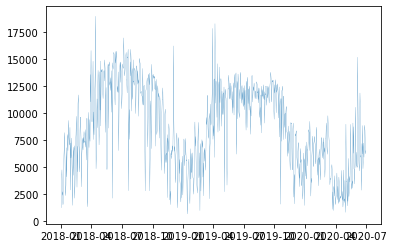

In [117]:
# plot number of rides over time
# df['started_at'] = pd.to_datetime(df['started_at'])
# df = df.set_index(['started_at'])
df_daily = df.number_rides.resample('1 D').sum()
print(df_daily)
print(df_daily.index)
print(df_daily[:])




fig = plt.figure()
ax = plt.axes()

ax.plot(df_daily.index, df_daily[:], linewidth=0.2)


# Compare Mar 2020 - Jun 2020 compared to 2018 and 2020 rides
#df = df[(df['started_at'].dt.month >= 1) & (df['started_at'].dt.month <= 2)]
#df['year'] = df['started_at'].apply(lambda x: x.year)
#print(df.groupby('year')['number_rides'].sum())




# df['year'] = df['year'].astype('category')
# #df['start_station_name'] = df['start_station_name'].astype('category')
# df['start_station_name'] = df['start_station_name'].astype(str)

# # print sample of columns
# # df1 = df.iloc[:1000]
# # df2 = df.iloc[-1000:]

# df_grouped = df.groupby(['start_station_name', 'year'])['number_rides'].count().unstack()
# df_grouped.columns = df_grouped.columns.astype(list)
# df_grouped.columns = ['2018', '2019', '2020']
# df_grouped = df_grouped[(df_grouped['2019'] != 0) & (df_grouped['2020'] != 0)]
# #df_grouped = df_grouped[df_grouped.index.str.contains("Metro")]


# df_grouped['% Change 2019-2020'] = (df_grouped['2020'] - df_grouped['2019'])/df_grouped['2019'] * 100
# #df_grouped['% Change 2019-2020'] = df_grouped['% Change 2019-2020'].sort_values(ascending=False)
# df_grouped = df_grouped.sort_values(by ='% Change 2019-2020' , ascending=False)

# #print(np.mean(df_grouped['% Change 2019-2020']))
# #print(np.sum(df_grouped['2019']))
